[*********************100%***********************]  1 of 1 completed


Available Columns: Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')
Epoch 1/100
24/24 [==============================] - 2s 28ms/step - loss: 0.0171 - val_loss: 0.0257
Epoch 2/100
24/24 [==============================] - 0s 13ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 3/100
24/24 [==============================] - 0s 13ms/step - loss: 8.8855e-04 - val_loss: 0.0018
Epoch 4/100
24/24 [==============================] - 0s 12ms/step - loss: 7.8340e-04 - val_loss: 0.0014
Epoch 5/100
24/24 [==============================] - 0s 13ms/step - loss: 7.3611e-04 - val_loss: 0.0014
Epoch 6/100
24/24 [==============================] - 0s 12ms/step - loss: 6.7992e-04 - val_loss: 0.0013
Epoch 7/100
24/24 [==============================] - 0s 12ms/step - loss: 6.1960e-04 - val_loss: 0.0016
Epoch 8/100
24/24 [==============================] - 0s 13ms/step - loss: 5.9161e-04 - val_loss: 0.0012
Epoch 9/100
24/24 [==============================] - 0s 12ms/ste

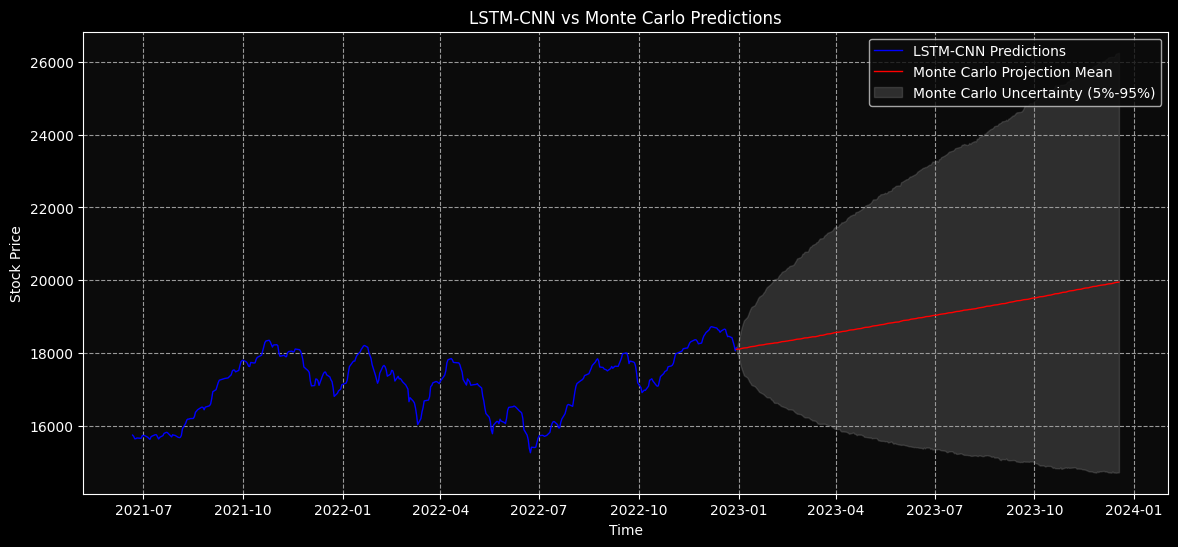

In [39]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

def download_stock_data(ticker, start, end):
    """Download and clean stock data."""
    stock_data = yf.download(ticker, start=start, end=end)

    if isinstance(stock_data.columns, pd.MultiIndex):
        stock_data.columns = stock_data.columns.get_level_values(0)
    columns_to_check = ['Open', 'High', 'Low', 'Close', 'Volume']
    print("Available Columns:", stock_data.columns)
    
    available_columns = [col for col in columns_to_check if col in stock_data.columns]
    
    if len(available_columns) == 0:
        raise KeyError(f"None of the required columns ({columns_to_check}) are available in the stock data.")
    
    for column in available_columns:
        stock_data[column] = pd.to_numeric(stock_data[column], errors='coerce')

    stock_data.dropna(subset=available_columns, inplace=True)
    
    return stock_data

def preprocess_data(stock_data, column='Close'):
    """Preprocess the stock data for LSTM-CNN."""
    data = stock_data[column].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

def create_dataset(data, time_step=60):
    """Create input/output dataset for LSTM."""
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

def build_lstm_cnn_model(time_step):
    """Build the LSTM-CNN model."""
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(time_step, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def monte_carlo_simulation(stock_data, num_simulations=10000, num_days=252):
    """Monte Carlo simulation for stock price projections."""
    log_returns = np.log(stock_data['Close'] / stock_data['Close'].shift(1))
    mu = log_returns.mean()
    sigma = log_returns.std()
    print(f"Mean daily return (mu): {mu}")
    print(f"Volatility (sigma): {sigma}")
    last_price = stock_data['Close'].iloc[-1]
    simulated_prices = np.zeros((num_simulations, num_days))

    for i in range(num_simulations):
        simulated_prices[i, 0] = last_price
        for t in range(1, num_days):
            random_shock = np.random.normal(0, 1)
            simulated_prices[i, t] = simulated_prices[i, t-1] * np.exp((mu - 0.5 * sigma**2) + sigma * random_shock)

    projection_mean = np.mean(simulated_prices, axis=0)
    projection_lower = np.percentile(simulated_prices, 5, axis=0)
    projection_upper = np.percentile(simulated_prices, 95, axis=0)

    return projection_mean, projection_lower, projection_upper

def plot_predictions(stock_data, test_predict, future_index, projection_mean, projection_lower, projection_upper):
    """Plot LSTM-CNN and Monte Carlo predictions."""
    plt.figure(figsize=(14, 6))

    test_start_idx = len(stock_data) - len(test_predict)

    plt.plot(stock_data.index[test_start_idx:], test_predict, label='LSTM-CNN Predictions', color='blue')

    plt.plot(future_index, projection_mean, color='red', label='Monte Carlo Projection Mean')
    plt.fill_between(future_index, projection_lower, projection_upper, color='gray', alpha=0.3, label='Monte Carlo Uncertainty (5%-95%)')

    plt.title('LSTM-CNN vs Monte Carlo Predictions')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    stock_data = download_stock_data('^NSEI', '2015-01-01', '2023-01-01')
    scaled_data, scaler = preprocess_data(stock_data)

    time_step = 60
    X, y = create_dataset(scaled_data, time_step)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    model = build_lstm_cnn_model(time_step)
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
    test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))

    projection_mean, projection_lower, projection_upper = monte_carlo_simulation(stock_data)

    future_index = pd.date_range(start=stock_data.index[-1], periods=252, freq='B')

    plot_predictions(stock_data, test_predict, future_index, projection_mean, projection_lower, projection_upper)

if __name__ == '__main__':
    main()
